In [1]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio


In [2]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))


TensorFlow version : 2.12.0
Num GPUs Available:  0


In [3]:
train_dir = r"C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\ml facial expression dataset\\train"
test_dir = r"C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\ml facial expression dataset\\test"

row, col = 48, 48
classes = 7


def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + "/" + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df


train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)


       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


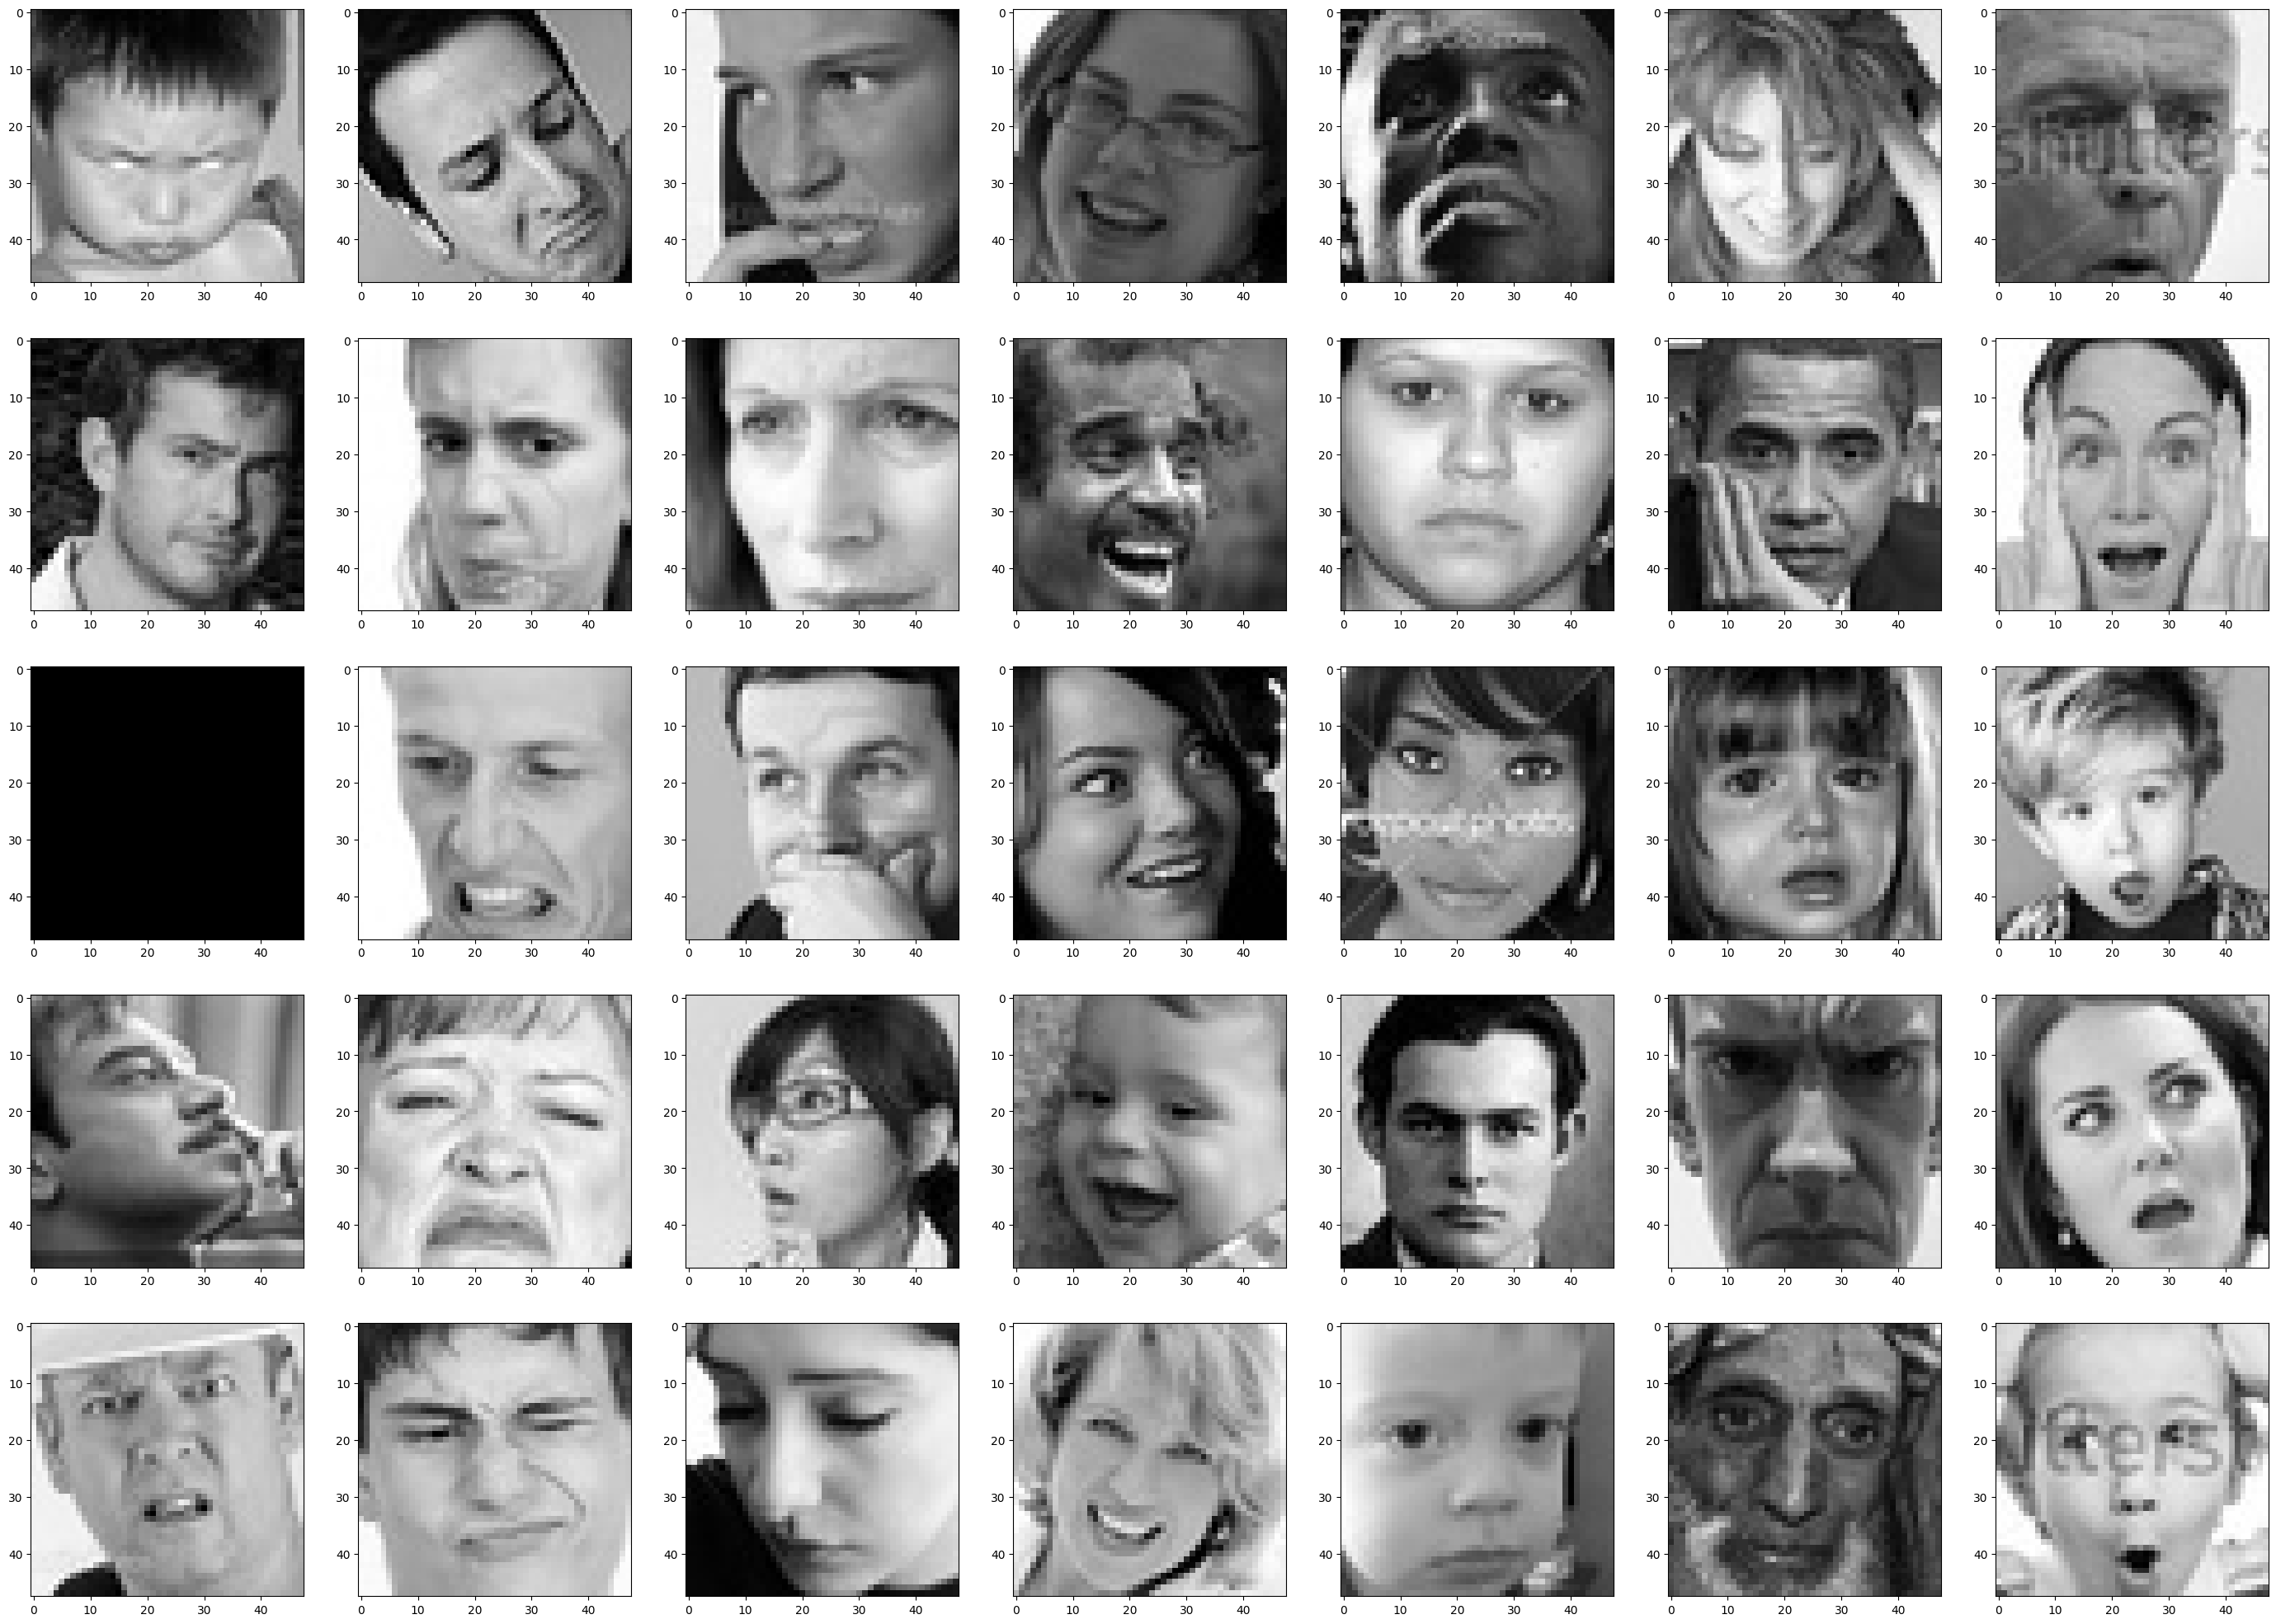

In [4]:
from skimage.io import imread
train_dir = "C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\ml facial expression dataset\\train\\"
test_dir = "C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\ml facial expression dataset\\test\\"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y, v in zip(range(total_labels), os.listdir(train_dir)):
        ax[x][y].imshow(
            imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()


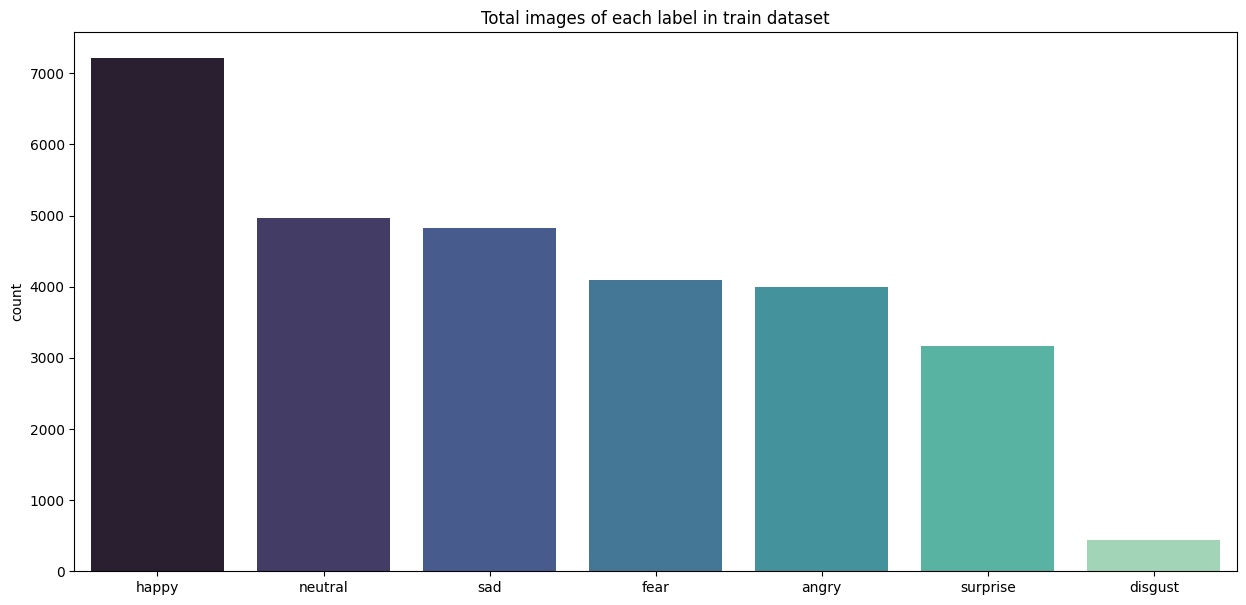

In [5]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose(
).sort_values("total", ascending=False)

plt.figure(figsize=(15, 7))
sns.barplot(x=df.index, y="total", palette="mako", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()


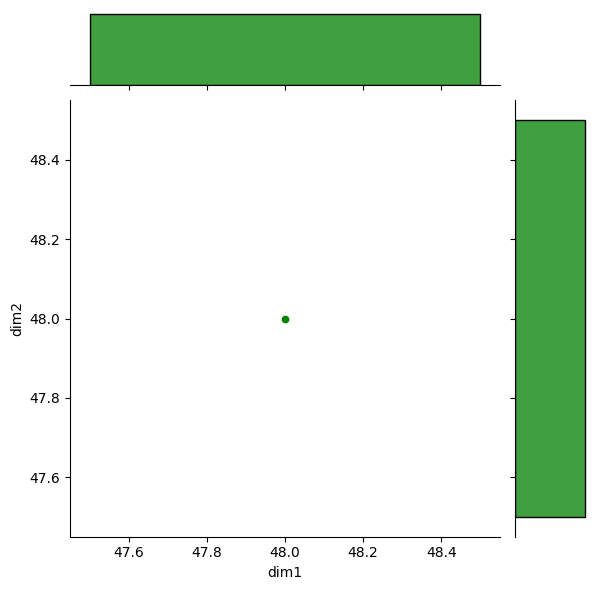

In [6]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

df = pd.DataFrame({'dim1': dim1, 'dim2': dim2})
sns.jointplot(data=df, x='dim1', y='dim2', color='g')
plt.show()


In [7]:
train_gen = ImageDataGenerator(rescale=1/255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(
                                                    img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                              target_size=(
                                                  img_shape[0], img_shape[1]),
                                              color_mode='grayscale',
                                              batch_size=64,
                                              class_mode='categorical',
                                              shuffle=False)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same',
          activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(
    3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(
    3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(
    3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

In [9]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,
                                                        decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    # callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)


Epoch 1/20
448/448 [==============================] - 558s 1s/step - loss: 1.8755 - accuracy: 0.2251 - val_loss: 2.4522 - val_accuracy: 0.1900
Epoch 2/20
448/448 [==============================] - 570s 1s/step - loss: 1.8058 - accuracy: 0.2433 - val_loss: 1.8302 - val_accuracy: 0.2524
Epoch 3/20
448/448 [==============================] - 568s 1s/step - loss: 1.7912 - accuracy: 0.2526 - val_loss: 1.7645 - val_accuracy: 0.2670
Epoch 4/20
448/448 [==============================] - 564s 1s/step - loss: 1.7736 - accuracy: 0.2658 - val_loss: 1.7401 - val_accuracy: 0.2891
Epoch 5/20
448/448 [==============================] - 589s 1s/step - loss: 1.7659 - accuracy: 0.2726 - val_loss: 1.6457 - val_accuracy: 0.3419
Epoch 6/20
448/448 [==============================] - 556s 1s/step - loss: 1.7400 - accuracy: 0.2890 - val_loss: 1.6378 - val_accuracy: 0.3560
Epoch 7/20
448/448 [==============================] - 614s 1s/step - loss: 1.7166 - accuracy: 0.3024 - val_loss: 1.6435 - val_accuracy: 0.3564

In [11]:
model.save("model.h5")


In [12]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)


113/113 [==============================] - 32s 280ms/step - loss: 1.1636 - accuracy: 0.5502
validation accuracy : 55.01532554626465%
validation loss : 1.163649320602417


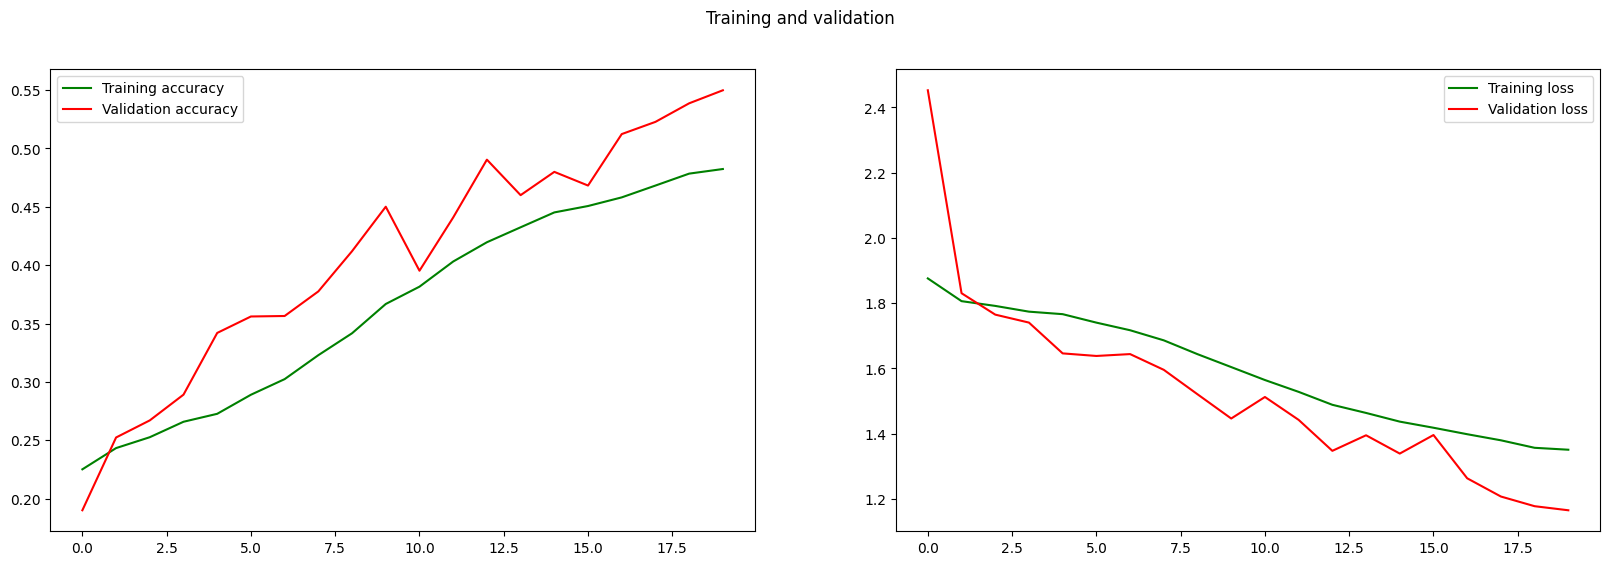

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()


113/113 [==============================] - 32s 280ms/step
              precision    recall  f1-score   support

       angry       0.42      0.45      0.43       958
     disgust       0.00      0.00      0.00       111
        fear       0.38      0.10      0.15      1024
       happy       0.75      0.84      0.80      1774
     neutral       0.46      0.64      0.54      1233
         sad       0.43      0.40      0.42      1247
    surprise       0.62      0.76      0.68       831

    accuracy                           0.55      7178
   macro avg       0.44      0.46      0.43      7178
weighted avg       0.52      0.55      0.52      7178





c:\Users\dawns\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dawns\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dawns\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

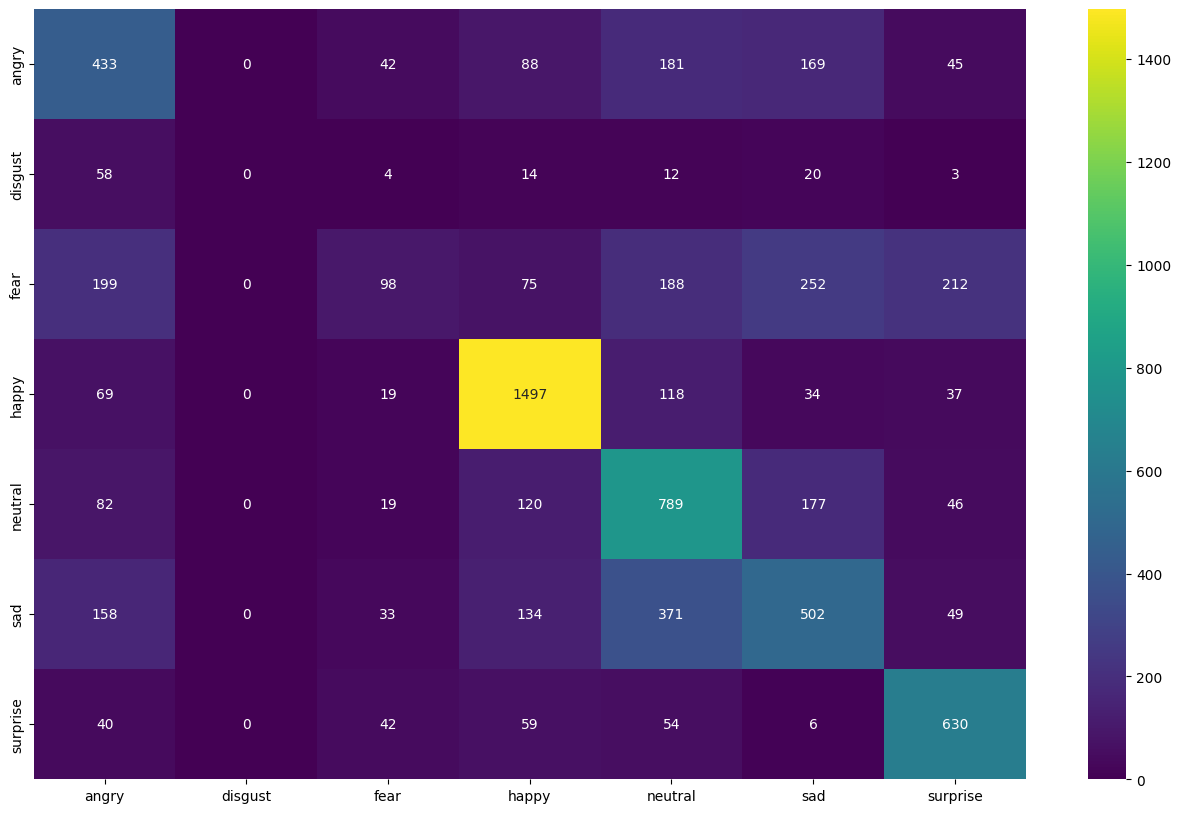

In [14]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred,
      target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16, 10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f',
            xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()


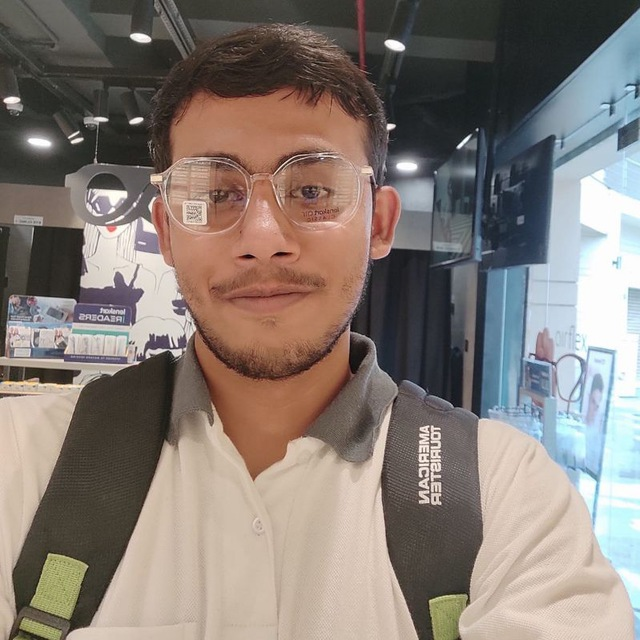

In [2]:
from IPython.display import Image
image = cv2.imread(
    "C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\im.jpg")
Image(filename="C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\im.jpg")


In [3]:
import cv2
from tensorflow.python.keras.models import load_model
import os

# Load the trained model
model = tf.keras.models.load_model("model.h5",
                                   custom_objects={'Functional': tf.keras.models.Model})
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, convert to grayscale, and normalize
frame = cv2.resize(img, (48, 48), interpolation=cv2.INTER_LINEAR)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reshape the image dimension
gray = gray.reshape(1, 48, 48, 1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i, j) in zip(range(7), EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j) + " prediction rate is   {0:.2f}%".format(predictss))
print("\n\n The system considers this expression to be:", label)


1/1 [==============================] - 1s 542ms/step
  Angry    prediction rate is   0.09%
 Disgust   prediction rate is   0.01%
  Happy    prediction rate is   0.19%
   Sad     prediction rate is   0.10%
 Surprise  prediction rate is   0.32%
 Neutral   prediction rate is   0.15%


 The system considers this expression to be: Surprise


In [4]:
import random
from IPython.display import Audio, display

if label == 'Angry':
    path = "C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\songs\\Angry\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(
        filename="C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\songs\\Angry\\"+ d, autoplay=True)
    display(audio)

elif label == 'Disgust':
    path = "C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\songs\\Disgust\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(
        filename="C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\songs\\Disgust\\" + d, autoplay=True)
    display(audio)

elif label == "Happy":
    path = "C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\songs\\Happy\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(
        filename="C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\songs\\Happy\\" + d, autoplay=True)
    display(audio)

elif label == 'Sad':
    path = "C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\songs\\Sad\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(
        filename="C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\songs\\Sad\\" + d, autoplay=True)
    display(audio)

elif label == 'Surprise':
    path = "C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\songs\\Surprise\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(
        filename="C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\songs\\Surprise\\" + d, autoplay=True)
    display(audio)

elif label == 'Neutral':
    path = "C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\songs\\Neutral\\"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(
        filename="C:\\Users\\dawns\\OneDrive\\Desktop\\Let's Grow More Projects\\10.ML Facial recognition to detect mood and suggest songs accordingly\\songs\\Neutral\\" + d, autoplay=True)
    display(audio)


Now Playing: Lungi Dance.mp3
